<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/09_gridsearch_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# overview

Uses actions and an input state to predict the output state.

# imports

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import math
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras import metrics

2.0.0


# save folder

In [0]:
base_folder = './results'
notebook_folder = '09_gridsearch_rnn'
results_folder = os.path.join(base_folder, notebook_folder)
os.makedirs(results_folder, exist_ok=True)
print('results_folder : ', results_folder)

saved_model_weight = 'saved_weights'
saved_model_weight_path = os.path.join(results_folder, saved_model_weight)
os.makedirs(saved_model_weight_path, exist_ok=True)


results_folder :  ./results/09_gridsearch_rnn


# mount drive

In [0]:
file = 'dataset_all_01.csv'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
working dir: /content/drive/My Drive/xplane_data


# load data

## define features (actions & states)
actions and states at time t (t-1, t-2 ...) are the input for the network.

the states at time t + 1 are the desired output of the network.


In [0]:
col_m_time      = '   missn,_time '
col_t_time      = '   _totl,_time '
col_yaw_v       = '   ____Q,rad/s '

col_yaw_deg     = '   _beta,__deg '
col_roll_deg    = '   _roll,__deg '
col_roll_v      = '   ____R,rad/s '
col_pitch_deg   = '   pitch,__deg '
col_pitch_v     = '   ____P,rad/s '
col_alt         = '   __alt,ftmsl '
col_vv          = '   __VVI,__fpm '
col_v           = '   Vtrue,_ktas '
col_rpm_prop    = '   rpm_1,_prop '
col_throttle     = '   thro1,_part '

cols_state = [ 
    col_yaw_v,
    col_yaw_deg,
    col_roll_deg,
    col_roll_v,
    col_pitch_deg,
    col_pitch_v,
    col_vv,
    col_alt,
    col_v,

]

cols_time = [
    col_m_time,
    col_t_time,
]

col_elev_servo                  = '   _elev,servo '
col_ailrn_servo                  = '   ailrn,servo '
col_ruddr_servo                  = '   ruddr,servo '

cols_action = [
    col_elev_servo,
    col_ailrn_servo,
    col_ruddr_servo,
    col_rpm_prop,
    col_throttle,
]

# all input columns
cols_features = []
cols_features.extend(cols_state)
cols_features.extend(cols_action)

# orga column
col_dataset_index = 'dataset_index'
col_maneuver_index = 'maneuver_index'
col_maneuver_name = 'maneuver_name'
col_maneuver_datapoint_index = 'maneuver_datapoint_index'
col_maneuver_type = 'maneuver_type'
cols_org = [col_dataset_index, col_maneuver_index, col_maneuver_name,
            col_maneuver_datapoint_index,col_maneuver_type]



## load data

In [0]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter=',', usecols = columns, 
                       float_precision='high')

df_data = load_xplane_csv(file, cols_org + cols_state + cols_action)

print(len(cols_org))
print(len(cols_state))
print(len(cols_action))
print(df_data.shape)
df_data.describe()

5
9
5
(477893, 19)


,dataset_index,maneuver_index,maneuver_name,maneuver_type,maneuver_datapoint_index,"Vtrue,_ktas","__VVI,__fpm","____Q,rad/s","____P,rad/s","____R,rad/s","pitch,__deg","_roll,__deg","_beta,__deg","__alt,ftmsl","thro1,_part","rpm_1,_prop","_elev,servo","ailrn,servo","ruddr,servo"
count,477893.000000,477893.000000,477893.0,477893.0,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.000000,477893.0
mean,3.412239,325.368333,0.0,0.0,862.572494,119.568747,31.844121,0.003809,-0.000023,-0.001838,-0.653922,-0.790419,0.006392,2714.285311,0.837608,2490.437417,-0.000023,-0.014557,0.0
std,1.823226,157.634998,0.0,0.0,966.076050,10.111832,274.837876,0.007105,0.017344,0.023891,1.683830,8.871232,0.137610,1357.542685,0.082120,127.213115,0.002302,0.022656,0.0
min,0.000000,0.000000,0.0,0.0,0.000000,66.424780,-1917.888180,-0.039450,-0.109810,-0.054820,-9.313510,-23.851520,-0.689970,805.092900,0.796080,2106.257810,-0.089790,-0.159740,0.0
25%,2.000000,186.000000,0.0,0.0,210.000000,116.120100,-38.803360,-0.000010,-0.000410,-0.010810,-1.284890,-4.041060,-0.082270,1411.217410,0.796080,2424.065920,-0.000110,-0.017030,0.0
50%,4.000000,350.000000,0.0,0.0,476.000000,118.826010,0.342680,0.001120,0.000000,-0.000020,-0.787270,-0.104740,0.004460,2620.899900,0.796080,2458.400630,-0.000000,-0.015220,0.0
75%,4.000000,452.000000,0.0,0.0,1223.000000,122.749510,164.749950,0.010130,0.000390,0.000830,-0.152690,0.207650,0.072860,3896.197020,0.796080,2504.575440,0.000070,-0.011370,0.0
max,7.000000,602.000000,0.0,0.0,7179.000000,155.436650,978.538330,0.041650,0.111310,0.055400,11.796170,25.924920,0.353550,5080.888180,1.000000,2811.808840,0.045100,0.124900,0.0


# define data preperation functions

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, cols_label=None):
	data_in = data.drop(cols_org, axis=1)
	if cols_label == None:
		data_out = data_in.drop(cols_action, axis=1)
	else:
		if type(cols_label) != list:
			cols_label = [cols_label]
		data_out = data_in[cols_label]

	cols_in = data_in.columns
	cols_out = data_out.columns
	cols, names = list(), list()
	# input sequence (t-n, ... t-1, t)
	for i in range(n_in, 0, -1):
		cols.append(data_in.shift(i))
		if i == 1:
			names += [('%s(t)' % (col_in)) for col_in in cols_in]
		else:
			names += [('%s(t-%d)' % (col_in, i-1)) for col_in in cols_in]

	# forecast sequence (t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(data_out.shift(-i))
		names += [('%s(t+%d)' % (col_out, i+1)) for col_out in cols_out]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg, cols_out

In [0]:
def split_feature_label(data_labeled, n_input_steps):
  data_X = data_labeled.values[:, 0:n_input_steps*len(cols_features)]
  data_Y = data_labeled.values[:, n_input_steps*len(cols_features):]
  return data_X, data_Y

In [0]:
def scale_data(data_X, data_Y):
  feature_scaler = MinMaxScaler()
  data_X = feature_scaler.fit_transform(data_X)
  label_scaler = MinMaxScaler()
  data_Y = label_scaler.fit_transform(data_Y)
  return feature_scaler, label_scaler, data_X, data_Y

In [0]:
def prepare_datasets_rnn(data, n_in=1, n_out=1, cols_label=None):
  #train-test-split
  test = data.query('dataset_index==4')
  train = data.query('dataset_index!=4')
  
  #add-label
  test_labeled, labels = series_to_supervised(test, n_in=n_in, n_out=n_out,
                                              dropnan=True, cols_label=cols_label)
  train_labeled, labels = series_to_supervised(train, n_in=n_in, n_out=n_out,
                                               dropnan=True, cols_label=cols_label)
  

  #split-feature-label
  train_X, train_Y = split_feature_label(train_labeled, n_in)
  test_X, test_Y = split_feature_label(test_labeled, n_in)
  


  #scale-feat
  feature_scaler, label_scaler, train_X, train_Y = scale_data(train_X, train_Y)
  #scale-label
  test_X, test_Y = feature_scaler.transform(test_X), label_scaler.transform(test_Y)

  #reshape to [samples, timesteps, features]
  n_features = int(train_X.shape[1]/n_in)
  train_X = train_X.reshape(train_X.shape[0],n_in, n_features)
  test_X = test_X.reshape(test_X.shape[0],n_in, n_features) 
  
  return train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels



# train models

## define callbacks functions

In [0]:
def prepare_tensorboard_callback(model_name=''):
  logs_base_dir = "./tensorbaord_logs"
  model_log_dir = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name
  target_log_dir = os.path.join(logs_base_dir, model_log_dir)
  os.makedirs(target_log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(target_log_dir, histogram_freq=1)
  return tensorboard_callback


In [0]:
def prepare_checkpoint_callback(model_name):
  checkpoint_base_dir = './checkpoints'
  os.makedirs(checkpoint_base_dir, exist_ok=True)
  filepath = os.path.join(checkpoint_base_dir, 'cp_'+ model_name)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  verbose=1)
  return cp_callback 

## define plot_and_save functions

### loss historie

In [0]:
def save_plots_before_show(diagramm_name):
  if not os.path.exists(results_folder):
      os.makedirs(diagramm_folder)

  plt.savefig(results_folder + '/' + diagramm_name +'.pdf')
  plt.savefig(results_folder + '/' + diagramm_name +'.svg')
  plt.savefig(results_folder + '/' + diagramm_name +'.png')

def pas_history(model_tupels, histories, key='mean_squared_error'):
  model_names = [model_tupel[0] for model_tupel in model_tupels]
  plt.figure(figsize=(16,10))
  for i, history in enumerate(histories):
    history_epoch= range(0, len(history['loss']) )

    val = plt.plot(history_epoch, history['val_'+key],
                   '--', label=model_names[i]+' Val')
    plt.plot(history_epoch, history[key], color=val[0].get_color(),
             label=model_names[i]+' Train')

  plt.xlabel('Epochs')
  plt.yscale("log")

  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history_epoch)])
  save_plots_before_show('history_loss'+'_'+key )
  plt.show()

### metrics (overall and for all single targets )



In [0]:
def pas_metrics_scaled(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=True)
  file_path = os.path.join(results_folder, model_name + '_scaled.csv')
  df.to_csv(path_or_buf=file_path)
  return df
  
def pas_metrics(model_tupel):
  model_name = model_tupel[0]
  df = _df_prediction_metrics(model_tupel, scaled=False)
  file_path = os.path.join(results_folder, model_name + '.csv')
  df.to_csv(path_or_buf=file_path)
  return df


def _df_prediction_metrics(model_tupel, scaled):
  '''
  creates describe dataframe of labels and 
  connect them with mse,rmse and mae per target and overall 
  '''
  
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  rmses = np.array([math.sqrt(mse) for mse in mses])
  maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=['mses'],     # index
            columns=cols_label)  #  column names
  df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
        index=['rmes'],     # index
        columns=cols_label)  #  column names
  df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
        index=['maes'],     # index
        columns=cols_label)  #  column names
  
  
  df_mse_all = pd.DataFrame(data=mse,    # values
            index=['mse'],     # index
            columns=cols_label)  #  column names
  df_rmse_all = pd.DataFrame(data=rmse,    # values
        index=['rme'],     # index
        columns=cols_label)  #  column names
  df_mae_all = pd.DataFrame(data=mae,    # values
        index=['mae'],     # index
        columns=cols_label)  #  column names
  

  metrics = [df_mse_per_feature, df_rmse_per_feature, df_mae_per_feature, 
             df_mse_all,df_rmse_all,df_mae_all]
  return df_describe.append(metrics)

## define models

In [0]:
def create_rnn(model_name, layers, keras_activation, kernel_initializer, 
                 loss, metrics,  n_in=1, n_out=1, cols_label=None):
  if not layers:
    raise Exception('No layers defined. Expected in format [100,100]') 

 #prepare data
  train_X, train_Y, test_X, test_Y, feature_scaler, label_scaler, labels =  prepare_datasets_rnn(df_data, n_in, n_out, cols_label=cols_label)
  features_nr = train_X.shape[1]
  target_nr = train_Y.shape[1]

   
  model = keras.Sequential(name=model_name)
  
    
  model.add(SimpleRNN(layers[0], input_shape=(n_in,train_X.shape[2]),
                        #input_shape=(train_X.shape[1], train_X.shape[2]),
                        kernel_initializer=kernel_initializer))
  
  for i in range(1, len(layers)):
    layer_val = layers[i]
    model.add(SimpleRNN(layer_val, kernel_initializer=kernel_initializer))

  model.add(Dense(target_nr ))

  model.compile(optimizer='adam',
                        loss=loss,
                        metrics=metrics)

  model.summary()
  print(model.to_json())
  print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
  return (model_name, model, (train_X, train_Y, test_X, test_Y), label_scaler, labels)


In [0]:
loss='mean_squared_error',
metrics=['mean_squared_error', 'mean_absolute_error']


#trained with batch_size=1
rnn_50 = create_rnn('rnn_50', [50], ReLU, 'he_uniform', 
             loss, metrics, 2,1)

rnn_200 = create_rnn('rnn_200', [200], ReLU, 'he_uniform', 
             loss, metrics, 2,1)

rnn_400 = create_rnn('rnn_400', [400], ReLU, 'he_uniform', 
             loss, metrics, 2,1)

models = [
          rnn_50,
          rnn_200,
          rnn_400,
          ]

Model: "rnn_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 50)                3250      
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 459       
Total params: 3,709
Trainable params: 3,709
Non-trainable params: 0
_________________________________________________________________
{"class_name": "Sequential", "config": {"name": "rnn_50", "layers": [{"class_name": "SimpleRNN", "config": {"name": "simple_rnn_8", "trainable": true, "batch_input_shape": [null, 2, 14], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 50, "activation": "tanh", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 2.0, "mode": "fan_in", "distribution": "uniform", "see

## train, save and load model

In [0]:
def train_model(model_tupel, epochs, batch_size):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]

  callbacks = [
              #prepare_checkpoint_callback(model_name=model_name),
              prepare_tensorboard_callback(model_name=model_name)
              ]

  history = keras_model.fit(train_X,
                            train_Y,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_X, test_Y),
                            verbose=2,
                            callbacks=callbacks,
                            shuffle=False
                            )
  return history  

def _format_model_path(model_name):
  file_name = '{}_end'.format(model_name)
  return os.path.join(saved_model_weight_path, file_name)

def save_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  keras_model.save_weights(file_path)

def load_model(model_tupel):
  model_name = model_tupel[0]
  keras_model = model_tupel[1]
  file_path = _format_model_path(model_name)
  exact_file_path = file_path + '.index'
  if os.path.isfile(exact_file_path):
    print('load model {}'.format(model_name))
    keras_model.load_weights(file_path)
    return True
  else:
    return False

def _format_history_path(model_name):
  file_name = '{}_history_dict'.format(model_name)
  return os.path.join(results_folder, file_name)
  

def save_history(model_tupel, history):
  file_path = _format_history_path(model_tupel[0])
  with open(file_path, 'wb') as file_hist:
        pickle.dump(history.history, file_hist)
  

def load_history(model_tupel):
  file_path = _format_history_path(model_tupel[0])
  if not os.path.isfile(file_path):
    return dict()
  with open(file_path, 'rb') as file_hist:
    return pickle.load(file_hist)

In [0]:
histories = []
for model in models:
  train_X, train_Y, test_X, test_Y = model[2]


  if not load_model(model):
    print(model[0])
    history = train_model(model, epochs=50, batch_size=64)
    save_model(model)
    save_history(model, history)
    histories.append(history.history)
    print('*******************')
  else:
    history = load_history(model)
    histories.append(history)

load model rnn_50
rnn_200
Train on 330983 samples, validate on 146906 samples
Epoch 1/50
330983/330983 - 35s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0544 - val_loss: 0.4259 - val_mean_squared_error: 0.4259 - val_mean_absolute_error: 0.5607
Epoch 2/50
330983/330983 - 34s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0696 - val_loss: 0.1296 - val_mean_squared_error: 0.1296 - val_mean_absolute_error: 0.2682
Epoch 3/50
330983/330983 - 33s - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0696 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - val_mean_absolute_error: 0.2475
Epoch 4/50
330983/330983 - 33s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0606 - val_loss: 0.1127 - val_mean_squared_error: 0.1127 - val_mean_absolute_error: 0.2645
Epoch 5/50
330983/330983 - 34s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0642 - val_loss: 0.0878 - val_mean_squared_error: 0.0878 -

## visualize

### Test & Training Loss

In [0]:
for i, history in enumerate(histories):
  last_loss = history['loss'][-1]
  last_val_loss = history['val_loss'][-1]
  model_name = models[i][0]
  print('{} model last loss: {}'.format(model_name,last_loss))
  print('{} model last val loss: {}'.format(model_name,last_val_loss))
  print('*******')

rnn_50 model last loss: 0.00015621084461752514
rnn_50 model last val loss: 0.0025660983929435047
*******
rnn_200 model last loss: 0.0002938809458181079
rnn_200 model last val loss: 0.005796472876210638
*******
rnn_400 model last loss: 0.011603969058292925
rnn_400 model last val loss: 0.1251568097582233
*******


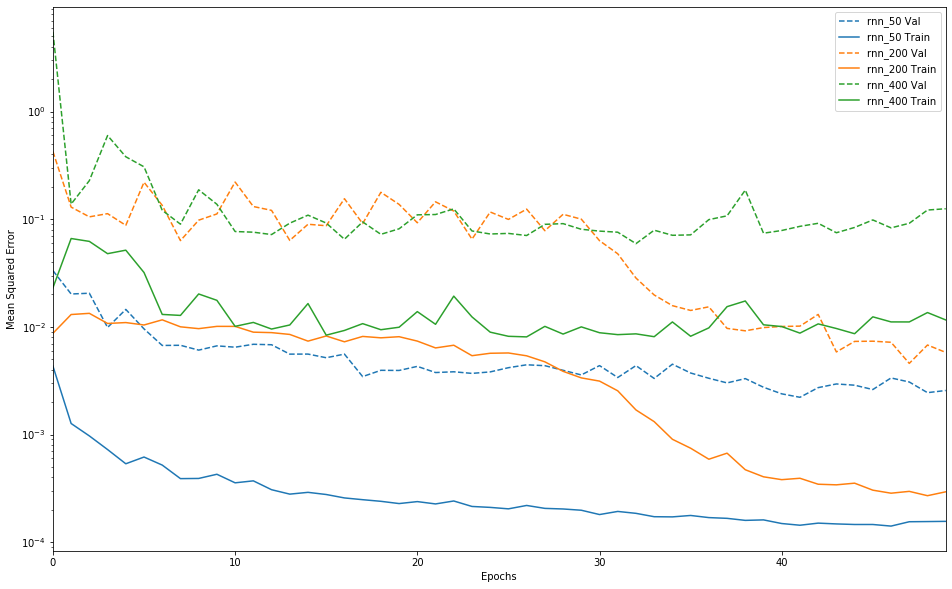

In [0]:
pas_history(models, histories=histories)


### MSE per target (scaled)

In [0]:
for model_tupel in models:
  df = pas_metrics_scaled(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                         'display.width', 1000): 
    print(df)
  print('*********************************************************')

rnn_50
          Vtrue,_ktas      __VVI,__fpm      ____Q,rad/s      ____P,rad/s      ____R,rad/s      pitch,__deg      _roll,__deg      _beta,__deg      __alt,ftmsl 
count    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000
mean          0.504411         0.737227         0.567109         0.485060         0.485233         0.531587         0.464654         0.620080         0.541120
std           0.106512         0.106115         0.097320         0.137144         0.297852         0.109146         0.243539         0.211064         0.313280
min          -0.145712         0.315198         0.068356        -0.114067         0.001815         0.194934         0.019929        -0.224448         0.020174
25%           0.491325         0.719309         0.479493         0.478066         0.141444         0.498650         0.178618         0.402814         0.258518
50%           0.516065         0.736735

### MSE per target (unscaled)

In [0]:
for model_tupel in models:
  df = pas_metrics(model_tupel)
  print(model_tupel[0])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.width', 1000):  
    print(df)
  print('*********************************************************')

rnn_50
          Vtrue,_ktas      __VVI,__fpm      ____Q,rad/s      ____P,rad/s      ____R,rad/s      pitch,__deg      _roll,__deg      _beta,__deg      __alt,ftmsl 
count    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000    146906.000000
mean        116.933706         1.454796         0.007136        -0.000140        -0.001338        -0.605149        -0.722679         0.024941      3118.809754
std           8.275038       276.266783         0.007759         0.025104         0.032829         1.788010        12.122505         0.178670      1339.522697
min          66.424780     -1097.281130        -0.032630        -0.109810        -0.054620        -6.120130       -22.859510        -0.689970       891.350710
25%         115.917000       -45.194615         0.000150        -0.001420        -0.039230        -1.144713       -14.960540        -0.158980      1910.463807
50%         117.839070         0.174215

## overall mse

In [0]:
def _df_prediction_metrics_all(model_tupel, scaled):
  
  model_name =  model_tupel[0]
  model = model_tupel[1]
  train_X, train_Y, test_X, test_Y = model_tupel[2]
  cols_label = model_tupel[4]


  pred_Y = model.predict(test_X)
  
  if scaled:
    truth_Y = test_Y
  else:
    label_scaler = model_tupel[3]
    pred_Y = label_scaler.inverse_transform(pred_Y)
    truth_Y = label_scaler.inverse_transform(test_Y)

  df_describe = pd.DataFrame(truth_Y,columns=cols_label).describe()
  mses = mean_squared_error(truth_Y, pred_Y, multioutput='raw_values')
  #rmses = np.array([math.sqrt(mse) for mse in mses])
  #maes = mean_absolute_error(truth_Y, pred_Y, multioutput='raw_values')
  # average over list should do the job as well
  mse = mean_squared_error(truth_Y, pred_Y)
  rmse = math.sqrt(mse)
  mae = mean_absolute_error(truth_Y, pred_Y)


  df_mse_per_feature = pd.DataFrame(data=mses.reshape(1,-1),    # values
            index=[model_name],     # index
            columns=cols_label)  #  column names
  
  df_mse_per_feature['MSE'] = mse
  df_mse_per_feature['RMSE'] = rmse
  df_mse_per_feature['MAE'] = mae


  #df_rmse_per_feature = pd.DataFrame(data=rmses.reshape(1,-1),    # values
   #     index=['rmes'],     # index
  #      columns=cols_label)  #  column names
  #df_mae_per_feature = pd.DataFrame(data=maes.reshape(1,-1),    # values
    #    index=['maes'],     # index
   #     columns=cols_label)  #  column names
  
  return df_mse_per_feature


def pas_metrics_all(models):
  cols_trans = ['MSE', 'RMSE', 'MAE', col_vv,col_alt, col_v]
  cols_rot = [col_roll_deg, col_pitch_deg, col_yaw_deg, col_pitch_v, col_yaw_v, col_roll_v]
  rows_trans = []
  rows_rot = []

  for model_tupel in models:
    model_row = _df_prediction_metrics_all(model_tupel, scaled=False)
    rows_trans.append(model_row[cols_trans])
    rows_rot.append(model_row[cols_rot])

  df_trans = pd.concat(rows_trans).round(2)
  file_path = os.path.join(results_folder, 'all_mse_trans' + '.csv')
  df_trans.to_csv(path_or_buf=file_path)
  
  df_rot = pd.concat(rows_rot).round(10)
  file_path = os.path.join(results_folder, 'all_mse_rot' + '.csv')
  df_rot.to_csv(path_or_buf=file_path)
  return df_trans, df_rot


df_trans, df_rot = pas_metrics_all(models)
  

In [0]:
df_trans

,MSE,RMSE,MAE,"__VVI,__fpm","__alt,ftmsl","Vtrue,_ktas"
rnn_50,5578.06,74.69,28.84,21045.12,29133.80,18.85
rnn_200,11496.18,107.22,37.80,18539.11,84816.31,105.91
rnn_400,735779.62,857.78,281.84,208549.99,6412668.68,459.65


In [0]:
df_rot

,"_roll,__deg","pitch,__deg","_beta,__deg","____P,rad/s","____Q,rad/s","____R,rad/s"
rnn_50,4.142196,0.654317,0.001832,0.000045,0.000017,0.000055
rnn_200,3.848744,0.407603,0.009024,0.000150,0.000030,0.000028
rnn_400,328.665393,9.454736,0.103200,0.006620,0.000316,0.001331


###predict one ahead

In [0]:
model_tupel = models[0]
model = model_tupel[1]
train_X, train_Y, test_X, test_Y = model_tupel[2]
label_scaler = model_tupel[3]
label = model_tupel[4]


In [0]:
test_X.shape

(146906, 2, 14)

In [0]:
def make_prediction(model, test_X, seq_len, n_labels):
  predictions = np.empty(n_labels).reshape(1,-1)  
  test_row = test_X[0,:].reshape(1,-1)
  for i in range(seq_len):
    pred_Y = model.predict(test_row)
    state_offset = pred_Y.shape[1]
    test_row = np.concatenate((pred_Y, test_X[i, state_offset:].reshape(1,-1)), axis=None).reshape(1,-1)
    predictions = np.concatenate((predictions,pred_Y))
  return np.delete(predictions, (0), axis=0) #delete first empty row
  
predictions = make_prediction(model, test_X, 200, len(cols_state))

ValueError: ignored

In [0]:
def get_descaled_dataframe(test_Y, predictions, label_scaler):
  truth = test_Y[:len(predictions),:]
  truth = label_scaler.inverse_transform(truth)
  predictions = label_scaler.inverse_transform(predictions)
  df_pred = pd.DataFrame(data=predictions, columns=label) 
  df_real = pd.DataFrame(data=truth, columns=label) 
  return df_real, df_pred

df_real, df_pred = get_descaled_dataframe(test_Y, predictions, label_scaler)

In [0]:
df_pred.describe()

In [0]:
df_real.describe()

In [0]:
def print_pred_and_actual(pred, actual):
  pred_columns = pred.columns
  actual_columns = actual.columns
  #pred_column_name = pred_columns[0]
  #actual_column_name = actual_columns[0]
  for pred_column_name, actual_column_name in zip(pred_columns,actual_columns):
    pred_column = pred[pred_column_name]
    actual_column = actual[actual_column_name]
    #for i in range(len(actual_column)):
    true = plt.plot(range(0, len(actual_column)), actual_column, label=pred_column_name+' true')
    plt.plot(range(0, len(actual_column)), pred_column,'--',color=true[0].get_color(), label=actual_column_name+' pred')
    plt.xlabel('Zeitschritte')
    plt.ylabel(pred_column_name)
    plt.legend()
    plt.show()


print_pred_and_actual(df_pred, df_real)


In [0]:
type(test_X[i,:])
